In [1]:
import os, time
from collections import deque
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

%matplotlib inline

# Data Loading

In [2]:
def load_sales(parse_date = True):
    data_fol = 'data'
    sales = pd.read_csv(os.path.join(data_fol, 'sales_train.csv'))
    if parse_date:
        date_col = pd.to_datetime(sales.date, format='%d.%m.%Y')
        sales.date = date_col
        sales['Month'] = sales.date.dt.to_period('M')
    return sales

def aggregate_monthly(sales_df):
    assert 'Month' in sales_df.columns, 'Month column not found'
    return (sales_df
            .groupby(['Month', 'shop_id', 'item_id'])
            .agg({'item_cnt_day': np.sum, 'item_price': np.mean})
            .rename(columns={'item_cnt_day':'item_cnt_month'})
           )

In [5]:
def load_all():
    sales = load_sales()
    agg_sales = aggregate_monthly(sales)
    items = pd.read_csv('data/items.csv')
    categories = pd.read_csv('data/item_categories.csv')
    test_set = pd.read_csv('data/test.csv')
    return agg_sales, items, categories, test_set

In [6]:
agg_sales, items, categories, test_set = load_all()

# Exploratory Data Analysis

Look at distribution of sales numbers

In [113]:
agg_sales.item_cnt_month.describe()

count    1.609123e+06
mean     2.267201e+00
std      8.649884e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.253000e+03
Name: item_cnt_month, dtype: float64

Look at distinct number of shops and items

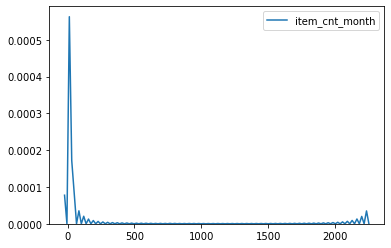

In [116]:
seaborn.kdeplot(agg_sales.item_cnt_month)

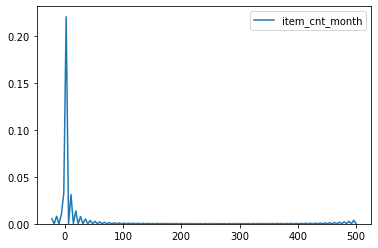

In [117]:
seaborn.kdeplot(np.clip(agg_sales.item_cnt_month,-100, 500))

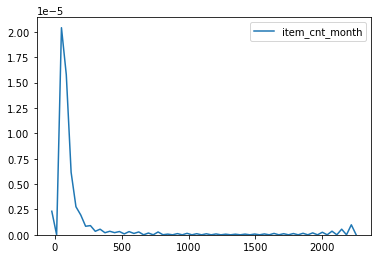

In [119]:
seaborn.kdeplot(agg_sales.item_cnt_month, gridsize=50)

Look at unique values

In [5]:
agg_sales.reset_index()[['Month','shop_id', 'item_id']].nunique()

Month         34
shop_id       60
item_id    21807
dtype: int64

distinct items per month per shop

In [6]:
agg_sales.reset_index().groupby('Month')[['shop_id', 'item_id']].nunique().head()

,shop_id,item_id
Month,,
2013-01,45,8115
2013-02,46,8168
2013-03,46,8302
2013-04,46,8145
2013-05,45,8339


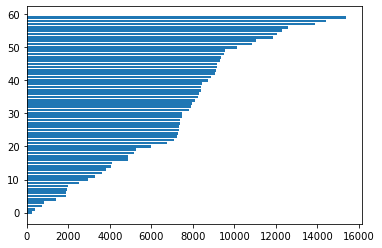

In [7]:
distinct_items_per_shop = agg_sales.reset_index().groupby('shop_id')['item_id'].nunique().sort_values()
plt.barh(range(distinct_items_per_shop.shape[0]), distinct_items_per_shop.values);

Some shops sell alot of items, and some shops sell very few - perhaps I need an encoding for shop id based on how many distinct items that shop sold

In [8]:
distinct_items_per_shop.loc[0]

3600

<br>
<hr>
<br>

Aggregate accross items and shops - and look at temporal behavior

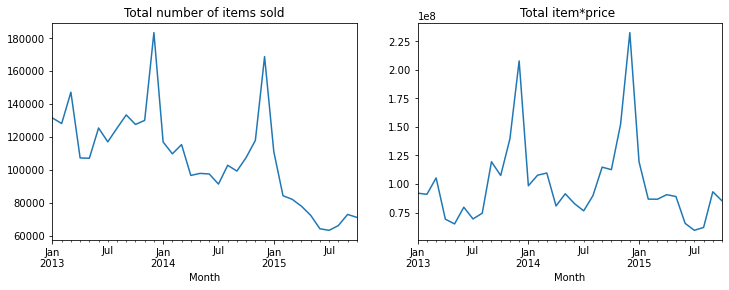

In [9]:
fig, ax  = plt.subplots(1,2)
fig.set_figwidth(12)
agg_sales.groupby(level=0).item_cnt_month.sum().plot(ax=ax[0])
ax[0].set_title('Total number of items sold')
agg_sales.groupby(level=0).apply(lambda x: (x.item_cnt_month*x.item_price).sum()).plot(ax=ax[1])
ax[1].set_title('Total item*price ')
plt.show()

* Decembers are clearly very different from all other months. Will need to either remove, or add a feature for this.
* Also there is a clear difference between summer months and winter months (holidays?)

In [10]:
monthly_agg = agg_sales.groupby(level=0).item_cnt_month.sum()
month_of_year = monthly_agg.reset_index().Month.dt.month.rename('MOY')
month_of_year.index = monthly_agg.index
temp = pd.concat([monthly_agg, month_of_year ], axis=1)

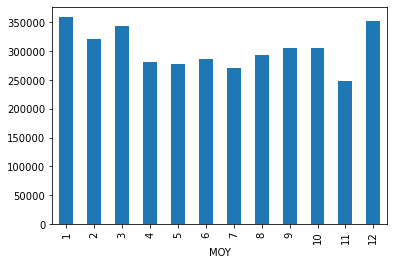

In [11]:
temp.groupby('MOY').item_cnt_month.sum().plot(kind='bar')

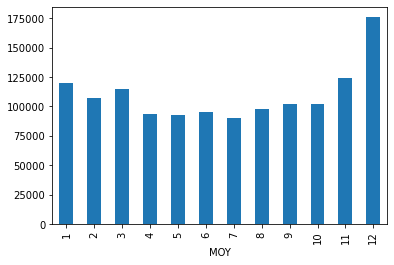

In [12]:
temp.groupby('MOY').item_cnt_month.mean().plot(kind='bar')

<br>
<hr>
<br>

## Project into items space

How many times we see each item in data set

In [13]:
item_appearances = agg_sales.groupby(level=2).item_cnt_month.count().sort_values()

In [14]:
item_appearances.head(10)

item_id
0       1
7509    1
7523    1
7537    1
7546    1
7547    1
7549    1
7550    1
7553    1
7555    1
Name: item_cnt_month, dtype: int64

In [15]:
(item_appearances == 1).sum()

2521

There are > 2000 items that we only see once! I need a feature to capture this.

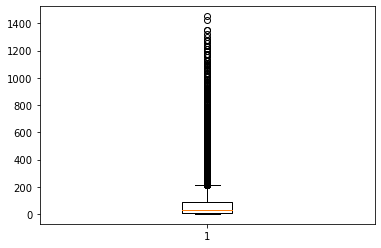

In [16]:
plt.boxplot(item_appearances);

Looks at num sales distribution accross items

In [17]:
aggregated_sales_per_item = agg_sales.groupby(level=2).item_cnt_month.sum()

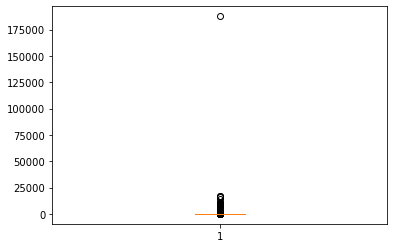

In [18]:
plt.boxplot(aggregated_sales_per_item);

In [19]:
aggregated_sales_per_item.sort_values()

item_id
1590        -11.0
13474        -1.0
11871        -1.0
18062        -1.0
13477         0.0
           ...   
5822      14515.0
17717     15830.0
3732      16642.0
2808      17245.0
20949    187642.0
Name: item_cnt_month, Length: 21807, dtype: float64

In [20]:
agg_sales.loc[pd.IndexSlice[:,:,20949], :].sort_values(by='item_cnt_month')

,,,item_cnt_month,item_price
Month,shop_id,item_id,,
2013-04,3,20949,1.0,5.000000
2015-09,2,20949,1.0,5.000000
2015-08,45,20949,1.0,5.000000
2015-07,52,20949,1.0,5.000000
2015-01,41,20949,1.0,5.000000
...,...,...,...,...
2014-12,25,20949,997.0,4.999769
2015-01,12,20949,1000.0,4.000000
2013-12,25,20949,1066.0,5.000000


In [21]:
items.query('item_id == 20949').item_name.values

array(['Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм'],
      dtype=object)

google says: 'Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм' -->'Branded jersey package 1C Interest white (34/42) 45 microns'

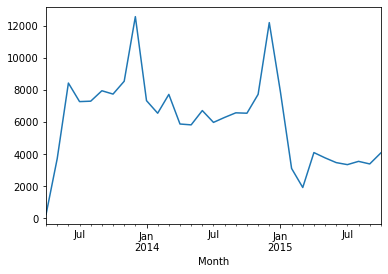

In [22]:
agg_sales.loc[pd.IndexSlice[:,:,20949], :].groupby(level=0).item_cnt_month.sum().plot()

Seems like a seasonal - winter vs summer thing

Perhaps I should create a feature for this specific item since it is sold so much more than anything else

<br>
<hr>
<br>

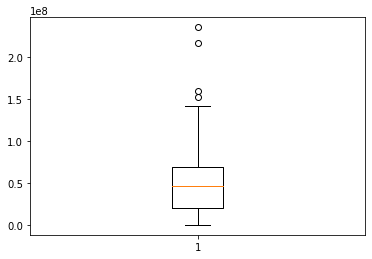

In [23]:
profit_per_shop = agg_sales.groupby(level=[0,1]).apply(lambda x: (x.item_cnt_month*x.item_price).sum()).unstack(level=1).fillna(0)
plt.boxplot(profit_per_shop.sum().sort_values());

In [24]:
item_life = pd.concat([agg_sales.reset_index().groupby('item_id').Month.min().rename('First'),
          agg_sales.reset_index().groupby('item_id').Month.max().rename('Last')], axis=1)

In [25]:
num_months = (item_life.Last - item_life.First).apply(lambda x: x.n + 1)

In [26]:
num_months.describe()

count    21807.000000
mean        14.046270
std          9.962316
min          1.000000
25%          5.000000
50%         13.000000
75%         21.000000
max         34.000000
dtype: float64

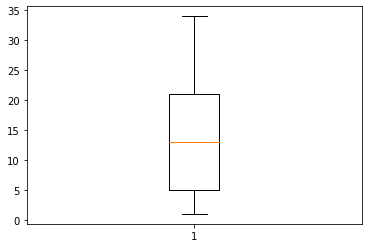

In [27]:
plt.boxplot(num_months);

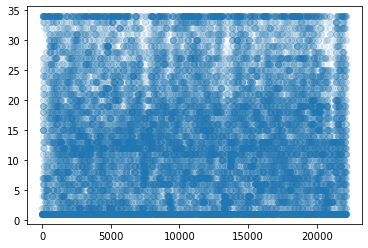

In [28]:
plt.scatter(num_months.index, num_months.values, alpha=0.1)

<br>
<hr>
<br>


Are lower priced items sold consistently more than higher priced items?

In [29]:
agg_sales.head()

item_cnt_month  item_price
Month   shop_id item_id                            
2013-01 0       32                  6.0       221.0
                33                  3.0       347.0
                35                  1.0       247.0
                43                  1.0       221.0
                51                  2.0       128.5

In [30]:
agg_sales_and_price = agg_sales.groupby(level=[0,2]).agg({'item_cnt_month':sum, 'item_price':max})

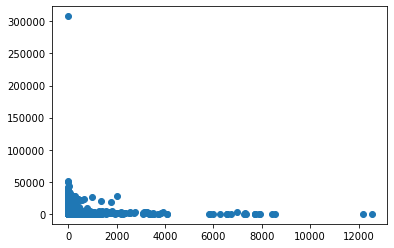

In [31]:
plt.scatter(agg_sales_and_price.item_cnt_month, agg_sales_and_price.item_price)

Is that one an outlier?

In [32]:
agg_sales.sort_values(by='item_price')

item_cnt_month     item_price
Month   shop_id item_id                               
2013-07 6       11872               1.0       0.090000
2013-06 58      11865               4.0       0.090000
        6       11864               7.0       0.094000
        58      20146               6.0       0.095833
        31      11872               8.0       0.100000
...                                 ...            ...
2015-10 22      13403               1.0   42990.000000
        3       13403               1.0   42990.000000
2015-01 12      7241                1.0   49782.000000
2014-03 25      13199               1.0   50999.000000
2013-12 12      6066                1.0  307980.000000

[1609124 rows x 2 columns]

In [33]:
items.query('item_id == 6066')

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


google says: 'Radmin 3 - 522 лиц' --> 'Radmin 3 - 522 persons'   

In [34]:
categories.query('item_category_id == 75')

,item_category_name,item_category_id
75,Программы - Для дома и офиса,75


google says: 'Программы - Для дома и офиса' --> 'Programs - For home and office'

In [35]:
idx_slice = pd.IndexSlice

In [36]:
agg_sales.loc[idx_slice[:,:,6066], :]

,,,item_cnt_month,item_price
Month,shop_id,item_id,,
2013-12,12,6066,1.0,307980.0


In [37]:
(test_set.item_id == 6066).any()

False

Only appears once, does not appear in test set - seems like an outlier; will drop

In [38]:
items.query('item_id == 13199')

,item_name,item_id,item_category_id
13199,Коллекционные шахматы (Властелин Колец),13199,69


google says: 'Коллекционные шахматы (Властелин Колец)' --> 'Collective Chess (Lord of the Rings)'

In [39]:
categories.query('item_category_id == 69')

,item_category_name,item_category_id
69,Подарки - Сувениры,69


google says: 'Подарки - Сувениры	' --> 'Gifts - Souvenirs'

In [40]:
idx_slice = pd.IndexSlice

In [41]:
agg_sales.loc[idx_slice[:,:,13199], :]

,,,item_cnt_month,item_price
Month,shop_id,item_id,,
2014-03,25,13199,1.0,50999.0


In [42]:
(test_set.item_id == 13199).any()

False

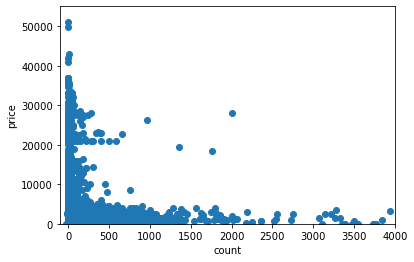

In [43]:
fig, ax = plt.subplots(1,1)
ax.scatter(agg_sales_and_price.item_cnt_month, agg_sales_and_price.item_price)
ax.set_xlim(-100, 4_000)
ax.set_ylim(0, 55_000)
ax.set_ylabel('price')
ax.set_xlabel('count');

No significant correlation

In [44]:
agg_sales_and_price.corr()

,item_cnt_month,item_price
item_cnt_month,1.000000,0.030912
item_price,0.030912,1.000000


Now Drop the outlier identified above

In [45]:
agg_sales = agg_sales.drop(6066, level=2)

In [46]:
agg_sales_and_price = agg_sales.groupby(level=[0,2]).agg({'item_cnt_month':sum, 'item_price':max})

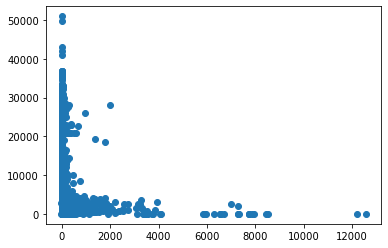

In [47]:
plt.scatter(agg_sales_and_price.item_cnt_month, agg_sales_and_price.item_price)

## Explore categories

In [48]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [49]:
categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [50]:
items_per_category = items.groupby('item_category_id').item_id.nunique().sort_values()

In [51]:
items_per_category.head()

item_category_id
79    1
10    1
51    1
1     2
50    2
Name: item_id, dtype: int64

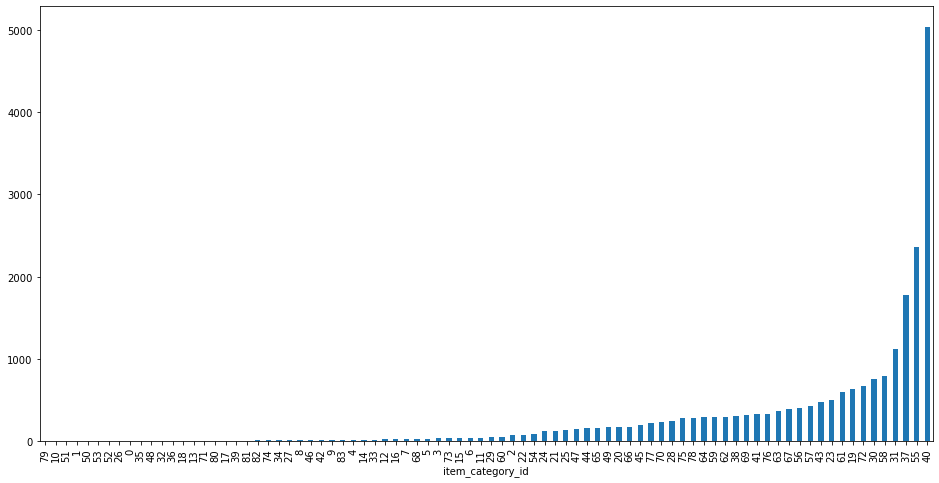

In [52]:
items_per_category.plot(kind='bar',  figsize=(16,8));

lets look at bigest category and see how sales are ditributed for items in that category

In [53]:
cat40_items = items.query('item_category_id == 40').item_id.values

In [54]:
idx = agg_sales.reset_index().item_id.isin(cat40_items)
subset = agg_sales.loc[idx.values]

In [55]:
subset.groupby(level=2).item_cnt_month.sum().describe()

count    4964.000000
mean      127.754029
std       257.226029
min         1.000000
25%        13.000000
50%        45.500000
75%       114.000000
max      3563.000000
Name: item_cnt_month, dtype: float64

It is a wide distribution

In [56]:
categories.query('item_category_id == 40')

,item_category_name,item_category_id
40,Кино - DVD,40


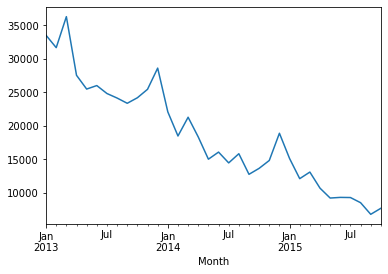

In [57]:
subset.groupby(level=0).item_cnt_month.sum().plot()

No suprise here - DVD sales have defenitely gone down recently

lets look second biggest category and see how sales are ditributed for items in that category

In [58]:
cat55_items = items.query('item_category_id == 55').item_id.values

In [59]:
idx = agg_sales.reset_index().item_id.isin(cat55_items)
subset = agg_sales.loc[idx.values]

In [60]:
subset.groupby(level=2).item_cnt_month.sum().describe()

count    2327.000000
mean      149.802750
std       233.988183
min         1.000000
25%        17.000000
50%        69.000000
75%       186.000000
max      2797.000000
Name: item_cnt_month, dtype: float64

It is a wide distribution

In [61]:
categories.query('item_category_id == 55')

,item_category_name,item_category_id
55,Музыка - CD локального производства,55


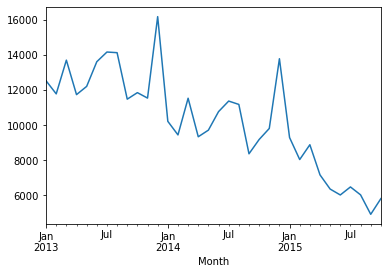

In [62]:
subset.groupby(level=0).item_cnt_month.sum().plot();

In [63]:
agg_sales

item_cnt_month  item_price
Month   shop_id item_id                            
2013-01 0       32                  6.0       221.0
                33                  3.0       347.0
                35                  1.0       247.0
                43                  1.0       221.0
                51                  2.0       128.5
...                                 ...         ...
2015-10 59      22087               6.0       119.0
                22088               2.0       119.0
                22091               1.0       179.0
                22100               1.0       629.0
                22102               1.0      1250.0

[1609123 rows x 2 columns]

In [135]:
cat_annotated_agg_sales = (pd.merge(agg_sales.reset_index(), items.drop('item_name', axis=1), on='item_id')
                           .set_index(['Month', 'shop_id', 'item_id'])
                           .sort_index(level=[0,1,2])
                          )

In [136]:
cat_annotated_agg_sales.head()

item_cnt_month  item_price  item_category_id
Month   shop_id item_id                                              
2013-01 0       32                  6.0       221.0                40
                33                  3.0       347.0                37
                35                  1.0       247.0                40
                43                  1.0       221.0                40
                51                  2.0       128.5                57

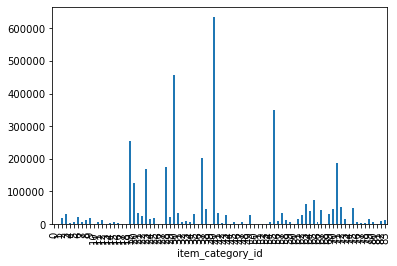

In [66]:
cat_annotated_agg_sales.groupby('item_category_id').item_cnt_month.sum().plot(kind='bar')

## Explore test set

In [67]:
test_set[['shop_id', 'item_id']].nunique()

shop_id      42
item_id    5100
dtype: int64

In [68]:
test_set.groupby('shop_id').item_id.nunique()

shop_id
2     5100
3     5100
4     5100
5     5100
6     5100
7     5100
10    5100
12    5100
14    5100
15    5100
16    5100
18    5100
19    5100
21    5100
22    5100
24    5100
25    5100
26    5100
28    5100
31    5100
34    5100
35    5100
36    5100
37    5100
38    5100
39    5100
41    5100
42    5100
44    5100
45    5100
46    5100
47    5100
48    5100
49    5100
50    5100
52    5100
53    5100
55    5100
56    5100
57    5100
58    5100
59    5100
Name: item_id, dtype: int64

When performing validation, I must do it over a set that looks like this: same items for all shops (but not the full universe of items).

I am creating such data frame now, that will be used to calculate error.

In [7]:
def create_submission_like_df():
    months = sorted(agg_sales.index.levels[0])
    submission_like_data  = {}
    for month in months:    
        month_data = agg_sales.loc[month]
        shops = set(month_data.index.get_level_values(0))
        item_ids = set(month_data.index.get_level_values(1))

        new_idx = pd.Index(product(shops, item_ids), name=month_data.index.name)
        submission_like_data[month] = month_data.reindex(new_idx).fillna({'item_cnt_month':0, 'item_price':-1})
        
    submission_like_df = pd.concat(submission_like_data)
    submission_like_df.index.names = agg_sales.index.names
    
    return submission_like_df

In [9]:
%%time
submission_like_df = create_submission_like_df()

Wall time: 21.4 s


In [14]:
submission_like_df.loc[agg_sales.index.levels[0][0]].reset_index().groupby('shop_id').item_id.nunique().head(10)

shop_id
0     8115
1     8115
2     8115
3     8115
4     8115
6     8115
7     8115
8     8115
10    8115
12    8115
Name: item_id, dtype: int64

# CHECKPOINT

In [18]:
agg_sales, items, categories, test_set = load_all()

In [19]:
agg_sales = agg_sales.drop(6066, level=2)

In [20]:
cat_annotated_agg_sales = (pd.merge(agg_sales.reset_index(), items.drop('item_name', axis=1), on='item_id')
                           .set_index(['Month', 'shop_id', 'item_id'])
                           .sort_index(level=[0,1,2])
                          )

In [21]:
submission_like_df = create_submission_like_df()

In [47]:
months = sorted(agg_sales.index.levels[0])

# Feature Generation

In [22]:
piv_agg_sales = agg_sales.item_cnt_month.unstack(level=0).fillna(0).sort_index()

In [23]:
piv_agg_sales.head()

Month            2013-01  2013-02  2013-03  2013-04  2013-05  2013-06  \
shop_id item_id                                                         
0       30           0.0     31.0      0.0      0.0      0.0      0.0   
        31           0.0     11.0      0.0      0.0      0.0      0.0   
        32           6.0     10.0      0.0      0.0      0.0      0.0   
        33           3.0      3.0      0.0      0.0      0.0      0.0   
        35           1.0     14.0      0.0      0.0      0.0      0.0   

Month            2013-07  2013-08  2013-09  2013-10  ...  2015-01  2015-02  \
shop_id item_id                                      ...                     
0       30           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        31           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        32           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        33           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        35           0.0      0.0      0.0      0.0  ...      0.0      0.0   

Month            2015-03  2015-04  2015-05  2015-06  2015-07  2015-08  \
shop_id item_id                                                         
0       30           0.0      0.0      0.0      0.0      0.0      0.0   
        31           0.0      0.0      0.0      0.0      0.0      0.0   
        32           0.0      0.0      0.0      0.0      0.0      0.0   
        33           0.0      0.0      0.0      0.0      0.0      0.0   
        35           0.0      0.0      0.0      0.0      0.0      0.0   

Month            2015-09  2015-10  
shop_id item_id                    
0       30           0.0      0.0  
        31           0.0      0.0  
        32           0.0      0.0  
        33           0.0      0.0  
        35           0.0      0.0  

[5 rows x 34 columns]

In [24]:
preprocessed_data = piv_agg_sales

## Sales Moving Averages

In [25]:
half_lifes = [1,2,3,6,9,12]

In [26]:
%%time
sales_ewms_mean = {tau:preprocessed_data.ewm(halflife=tau, axis=1, min_periods=tau).mean() for tau in half_lifes}
sales_ewms_std = {tau:preprocessed_data.ewm(halflife=tau, axis=1, min_periods=tau).std() for tau in half_lifes}

Wall time: 29.5 s


In [27]:
%%time
prices = agg_sales.item_price.unstack(level=0).fillna(0)
shop_monthly_income = (prices*preprocessed_data).groupby(level=0).transform('sum')
item_monthly_income = (prices*preprocessed_data).groupby(level=1).transform('sum')
items_income_ewms = {tau:item_monthly_income.ewm(halflife=tau, axis=1, min_periods=tau).mean() for tau in half_lifes}
shops_income_ewms = {tau:shop_monthly_income.ewm(halflife=tau, axis=1, min_periods=tau).mean() for tau in half_lifes}

Wall time: 31.2 s


### Rolling stats

In [28]:
windows = [3,6,9,12]

In [29]:
%%time
sales_rmin = {w:preprocessed_data.rolling(window=2, axis=1).min() for w in windows}
sales_rmedian = {w:preprocessed_data.rolling(window=2, axis=1).median() for w in windows}
sales_rmax = {w:preprocessed_data.rolling(window=2, axis=1).max() for w in windows}

Wall time: 2min 16s


## Mean Encode Shops

In [30]:
%%time
target_encode_shops_itemCounts = preprocessed_data.groupby(level=0).transform('sum')
target_encode_shops_uniqueItems = preprocessed_data.groupby(level=0).transform(lambda x: (x>0).sum())

targenc_shops_itemCounts_ewms = {tau:target_encode_shops_itemCounts.ewm(halflife=tau, axis=1, min_periods=tau).mean() for tau in half_lifes}
targenc_shops_uniqueItems_ewms = {tau:target_encode_shops_uniqueItems.ewm(halflife=tau, axis=1, min_periods=tau).mean() for tau in half_lifes}

Wall time: 27.6 s


## Encode Items

First item map to category, and encode how many items in that category sold that month

In [31]:
cat_sales = cat_annotated_agg_sales.groupby(['Month','item_category_id']).item_cnt_month.transform('sum')
cat_sales = cat_sales.unstack(level=0).fillna(0)
targenc_cat_sales = {tau:cat_sales.ewm(halflife=tau, axis=1, min_periods=tau).mean() for tau in half_lifes}

In [32]:
did_item_sell_that_month = piv_agg_sales.groupby('item_id').transform('max').astype(bool).astype(int)
sales_bool_rsum = {w:did_item_sell_that_month.rolling(window=w, axis=1).sum() for w in windows}

In [33]:
target_encode_items_totalMonthCounts = preprocessed_data.groupby(level=1).transform('sum')
targenc_items_totalMonthCounts_ewms = {tau:target_encode_items_totalMonthCounts.ewm(halflife=tau, axis=1, min_periods=tau).mean() for tau in half_lifes}

## Creating Objective

In [34]:
# Note that I use raw-data for objective 
objectives = piv_agg_sales.shift(-1, axis=1)

## Putting Features together and adding date features

In [35]:
sales_mean_features = {f'sales_ewms_mean_ewms{tau}': sales_ewms_mean[tau] for tau in half_lifes}
sales_std_features = {f'sales_ewms_std_ewms{tau}': sales_ewms_std[tau] for tau in half_lifes}

items_income_features = {f'items_income_ewms{tau}': items_income_ewms[tau] for tau in half_lifes}
shops_income_features = {f'shops_income_ewms{tau}': shops_income_ewms[tau] for tau in half_lifes}

sales_rmin_features = {f'sales_rmin{w}':sales_rmin[w] for w in windows}
sales_rmedian_features = {f'sales_rmed{w}':sales_rmedian[w] for w in windows}
sales_rmax_features = {f'sales_rmax{w}':sales_rmax[w] for w in windows}

targenc_shops_itemCounts_feats = {f'targenc_shops_itmCnts_ewms{tau}':targenc_shops_itemCounts_ewms[tau] for tau in half_lifes}
targenc_shops_uniqueItems_feats = {f'targenc_shops_uniqItms_ewms_{tau}':targenc_shops_uniqueItems_ewms[tau] for tau in half_lifes}

targenc_cat_sales_feats = {f'targenc_items_catMonthSales_ewms{tau}':targenc_cat_sales[tau] for tau in half_lifes}
sales_bool_rsum_feats = {f'targenc_items_boolMonthSales_rsum{w}':sales_bool_rsum[w] for w in windows}
targenc_items_totalMonthCounts_ewms_feats = {f'targenc_items_totalMnthCnt_ewms{tau}':targenc_items_totalMonthCounts_ewms[tau] for tau in half_lifes}

features_dict = {**sales_mean_features, **sales_std_features,
                 **items_income_features, **shops_income_features,
                 **sales_rmin_features, **sales_rmedian_features, **sales_rmax_features,
                 **targenc_shops_itemCounts_feats, **targenc_shops_uniqueItems_feats,
                 **targenc_cat_sales_feats, **sales_bool_rsum_feats, **targenc_items_totalMonthCounts_ewms_feats
                }

Helper function to get features for a single month of data

In [36]:
all_months = preprocessed_data.columns.tolist()
obj_month_map = dict(zip(all_months[:-1], all_months[1:]))

def get_single_month_XY(month_, drop_cols = None, num_lagged_values=0):
    cols = [df[month_].rename(name) for (name, df) in features_dict.items()]
    X = pd.concat(cols, axis=1)
    Y = objectives[month_]
    submission_Y = submission_like_df.item_cnt_month.loc[obj_month_map[month_]]
    
    if num_lagged_values > 0:
        idx = np.argmax(preprocessed_data.columns == month_)
        assert idx >= num_lagged_values, "do not have enough columns for desired lags"
        lagged_vals = preprocessed_data.iloc[:,idx-num_lagged_values:idx]
        lagged_vals.columns = [f'lag{lag}' for lag in list(range(1,num_lagged_values+1))[::-1]]
        X = pd.concat([X,lagged_vals], axis=1)
    
    # might turn this into separate function to pass into here
    X['month'] = month_.month
    X['season'] = X.month.map({1:0, 2:0, 3:0, 4:1, 5:1, 6:1, 7:1, 8:2, 9:2, 10:2, 11:3, 12:3})
    X['winter'] = X.month.map({**dict(zip([4,5,6,7,8,9,10], [False]*7)), **dict(zip([1,2,3,11,12], [True]*5))})
    
    if drop_cols is not None:
        X = X.drop(drop_cols, axis=1)
    
    X = pd.concat([X], keys=[month_], names=['Period'])
    Y = pd.concat([Y], keys=[month_], names=['Period'])
    submission_Y = pd.concat([submission_Y], keys=[month_], names=['Period'])
    
    return X,Y, submission_Y

# Simple Model

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [38]:
def fit_and_predict(model, x_train, y_train, x_val = None):
    
    start_time = time.time()
    fitted_model = model.fit(x_train, y_train)
    fit_time = time.time() - start_time
    fitted_model.col_names = x_train.columns
    
    y_train_pred = fitted_model.predict(x_train)
    
    if x_val is not None:
        y_val_pred = fitted_model.predict(x_val)
    else:
        y_val_pred = None
        
    return fitted_model, y_train_pred, y_val_pred, fit_time

In [39]:
def plot_feature_importances(mod, figsize=(6,10)):
    plt.figure(figsize=figsize)
    importances = mod.feature_importances_
    if type(importances) == pd.Series:
        importances.sort_values().plot(kind='barh')
    else:
        pd.Series(importances, index=mod.col_names).sort_values().plot(kind='barh')


In [40]:
def conform_to_subY(x, y_pred, y_sub_ser, fill_value=0):
    y_pred_ser = pd.Series(y_pred, index=x.index)
    y_pred_ser = y_pred_ser.reindex(y_sub_ser.index).fillna(0)
    return y_pred_ser
    

In [199]:
%%time
X_train, Y_train, Y_sub = get_single_month_XY(months[15])

Wall time: 1.01 s


In [200]:
X_train.shape

(424123, 67)

In [201]:
X_train.head()

sales_ewms_mean_ewms1  sales_ewms_mean_ewms2  \
Period  shop_id item_id                                                 
2014-04 0       30                    0.000946               0.071213   
                31                    0.000336               0.025269   
                32                    0.000397               0.032718   
                33                    0.000137               0.011765   
                35                    0.000443               0.033785   

                         sales_ewms_mean_ewms3  sales_ewms_mean_ewms6  \
Period  shop_id item_id                                                 
2014-04 0       30                    0.258203               0.796550   
                31                    0.091620               0.282647   
                32                    0.122956               0.394302   
                33                    0.044820               0.145761   
                35                    0.123219               0.382624   

                         sales_ewms_mean_ewms9  sales_ewms_mean_ewms12  \
Period  shop_id item_id                                                  
2014-04 0       30                    1.103571                1.284981   
                31                    0.391590                0.455961   
                32                    0.553752                0.649257   
                33                    0.205678                0.241727   
                35                    0.531347                0.619438   

                         sales_ewms_std_ewms1  sales_ewms_std_ewms2  \
Period  shop_id item_id                                               
2014-04 0       30                   0.209741              1.631878   
                31                   0.074424              0.579054   
                32                   0.073495              0.589200   
                33                   0.024859              0.206169   
                35                   0.094842              0.738221   

                         sales_ewms_std_ewms3  sales_ewms_std_ewms6  ...  \
Period  shop_id item_id                                              ...   
2014-04 0       30                   3.004810              5.111737  ...   
                31                   1.066223              1.813842  ...   
                32                   1.095871              1.875348  ...   
                33                   0.388150              0.672201  ...   
                35                   1.359115              2.309914  ...   

                         targenc_items_boolMonthSales_rsum12  \
Period  shop_id item_id                                        
2014-04 0       30                                      12.0   
                31                                      12.0   
                32                                      12.0   
                33                                      12.0   
                35                                       1.0   

                         targenc_items_totalMnthCnt_ewms1  \
Period  shop_id item_id                                     
2014-04 0       30                              27.487633   
                31                              17.531334   
                32                              42.295003   
                33                              24.866758   
                35                               0.256229   

                         targenc_items_totalMnthCnt_ewms2  \
Period  shop_id item_id                                     
2014-04 0       30                              35.127183   
                31                              20.208299   
                32                              53.773216   
                33                              28.447256   
                35                               0.682707   

                         targenc_items_totalMnthCnt_ewms3  \
Period  shop_id item_id                                     
2014-04 0       30      

In [166]:
Y_train.head()

Period   shop_id  item_id
2014-04  0        32         0.0
                  33         0.0
                  35         0.0
                  43         0.0
                  51         0.0
Name: 2014-04, dtype: float64

In [167]:
Y_sub.head()

Period   shop_id  item_id
2014-04  2        27         0.0
                  30         1.0
                  31         1.0
                  32         0.0
                  33         0.0
Name: item_cnt_month, dtype: float64

Try simple random forrest

In [169]:
mod = RandomForestRegressor(n_estimators=50, max_depth=5, n_jobs=-1)
fitted, ytpred, yvpred, elapsed = fit_and_predict(mod, X_train,Y_train)

In [170]:
elapsed, np.sqrt(mean_squared_error(Y_train, ytpred))

(47.10300850868225, 2.1230696015172774)

In [173]:
ytsub = conform_to_subY(X_train, ytpred, Y_sub)

In [176]:
np.sqrt(mean_squared_error(Y_sub, ytsub))

2.630582203325834

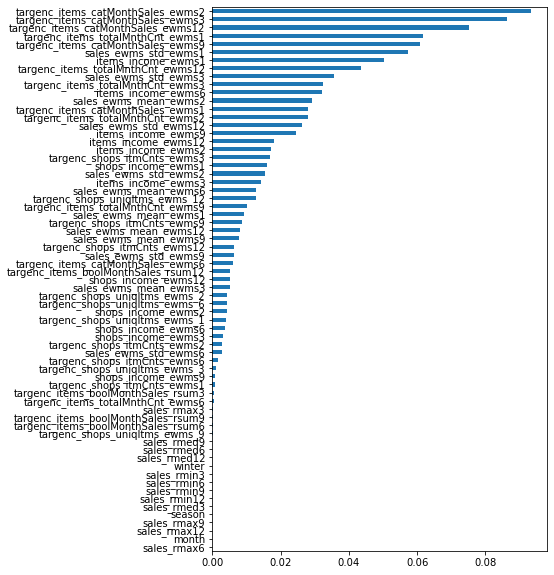

In [177]:
plot_feature_importances(fitted)

In [42]:
import xgboost as xgb

class xgb_model:
    def __init__(self, num_boost_round, **params):
        self.params = {
            'max_depth':6,
            'min_child_weight': 1,
            'eta':.3,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'lambda':1,
            'gamma':0.1,
            'objective':'reg:squarederror',
            # leave nthread default - detects all cores automatically
        }
        self.params.update(params)
        self.fitted_model = None
        self.num_boost_round = num_boost_round
       
    def fit(self, X, Y):
        dm_train = xgb.DMatrix(X,Y)
        self.fitted_model = xgb.train(self.params, dtrain=dm_train, num_boost_round=self.num_boost_round)
        return self
    
    def predict(self, X):
        assert self.fitted_model is not None, 'Must fit first'
        dm = xgb.DMatrix(X)
        return self.fitted_model.predict(dm)
    
    @property
    def feature_importances_(self):
        return pd.Series(self.fitted_model.get_score(importance_type='weight'))

In [41]:
mod = xgb_model(num_boost_round=50, max_depth=10, eta=0.2)
fitted, ytpred, yvpred, elapsed = fit_and_predict(mod, X_train,Y_train)

NameError: name 'xgb_model' is not defined

In [184]:
elapsed, np.sqrt(mean_squared_error(Y_sub, conform_to_subY(X_train, ytpred, Y_sub)))

(20.985515832901, 2.964144156925987)

# Rolling Cross Validation

Description if Cross of Model Fit and Cross Validation:

In [104]:
class results:
    def __init__(self, model, fitted_models, preSub_is_scores, preSub_oos_scores, is_scores, os_scores, times=None):
        self.model = model
        self.fitted_models = fitted_models
        self.preSub_is_scores = preSub_is_scores
        self.preSub_oos_scores = preSub_oos_scores
        self.is_scores = is_scores
        self.os_scores = os_scores
        self.times = times
        
    @property
    def keys(self):
        return sorted(self.fitted_models.keys())
        
    @property
    def scores(self):
        return pd.concat([pd.Series(self.preSub_is_scores, name='PreInSampleRMSE'), pd.Series(self.is_scores, name='inSampleRMSE'), pd.Series(self.preSub_oos_scores, name='PreOutSampleRMSE'), pd.Series(self.os_scores, name='outSampleRMSE')], axis=1)
        

In [105]:
def rolling_cross_validation(model, data_months_list, post_process_preds = None, num_lagged_values=12, validate_months_num=None, num_stack_months=1, pred_fill_value=0, fit_final=False, drop_cols=None):
    if post_process_preds is None:
        post_process_preds = lambda x: x
        
    Xs_deque = deque()
    Ys_deque = deque()
    Ysubs_deque = deque()
    
    for month in data_months_list[:num_stack_months]:
        X_, Y_, Ysub_= get_single_month_XY(month, drop_cols=drop_cols, num_lagged_values=num_lagged_values)
        Xs_deque.append(X_)
        Ys_deque.append(Y_)
        Ysubs_deque.append(Ysub_)
        
           
    max_validate_months = len(data_months_list) - num_stack_months - 1
    if validate_months_num is None:
        validate_months_num = max_validate_months
    else:
        validate_months_num = min(validate_months_num, max_validate_months)
        
    
    fitted_models = {}
    in_sample_scores = {}
    oos_scores = {}
    prepred_is_scores = {}
    prepred_os_scores = {}
    loop_times = []
    
    # REMOVE
    ys = {}
    Xs = {}
    yprepreds = {}
    ypreds = {}
    
    for month in data_months_list[num_stack_months: num_stack_months + validate_months_num]:
        print(f'Working on: {month}')
        loop_start = time.time()
        
        X_train = pd.concat(Xs_deque)
        Y_train = pd.concat(Ys_deque)
        Y_sub_train = pd.concat(Ysubs_deque)
        
        X_val, Y_val, Y_sub_val = get_single_month_XY(month, drop_cols=drop_cols, num_lagged_values=num_lagged_values)
        fitted, ytrain_pred, yval_pred, elapsed_time = fit_and_predict(model, X_train, Y_train, X_val)
        fitted_models[month] = fitted
        print(f'fit time: {elapsed_time}')
        
        prepred_is_scores[month] = np.sqrt(mean_squared_error(Y_train, ytrain_pred))
        prepred_os_scores[month] = np.sqrt(mean_squared_error(Y_val, yval_pred))
        
        #REMOVE
        Xs[month] = X_val
        yprepreds[month] = yval_pred
        
        ytrain_pred = conform_to_subY(X_train, ytrain_pred, Y_sub_train, fill_value=pred_fill_value)
        yval_pred = conform_to_subY(X_val, yval_pred, Y_sub_val, fill_value=pred_fill_value)
        
        ytrain_pred = post_process_preds(ytrain_pred)
        yval_pred = post_process_preds(yval_pred)
        
        # REMOVE
        ys[month] = Y_sub_val
        ypreds[month] = yval_pred
        
        in_sample_scores[month] = np.sqrt(mean_squared_error(Y_sub_train, ytrain_pred))
        oos_scores[month] = np.sqrt(mean_squared_error(Y_sub_val, yval_pred))
        
        Xs_deque.popleft()
        Ys_deque.popleft()
        Ysubs_deque.popleft()
        
        Xs_deque.append(X_val)
        Ys_deque.append(Y_val)
        Ysubs_deque.append(Y_sub_val)

        
        loop_end = time.time()
        loop_times.append(loop_end - loop_start)
    
    if fit_final:
        X_train = pd.concat(Xs_deque)
        Y_train = pd.concat(Ys_deque)
        Y_sub = pd.concat(Ysubs_deque)
        
        fitted, ytrain_pred, yval_pred, elapsed_time = fit_and_predict(model, X_train, Y_train, X_val)
        fitted_models['FINAL'] = fitted
        in_sample_scores['FINAL'] = np.sqrt(mean_squared_error(Y_train, post_process_preds(ytrain_pred)))
    
    
    return results(model, fitted_models, prepred_is_scores, prepred_os_scores, in_sample_scores, oos_scores, loop_times) #, Xs, ys, yprepreds, ypreds)

### TroubleShoot

In [106]:
mod = xgb_model(num_boost_round=5, max_depth=5, eta=0.3, gpu_id=0, tree_method='gpu_hist')
res1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, validate_months_num=2,  post_process_preds=lambda x: np.clip(x, 0,20), num_stack_months=12, fit_final=False)

Working on: 2015-02
fit time: 64.44188356399536
Working on: 2015-03
fit time: 80.80307078361511


In [107]:
res1.scores

,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-02,1.881822,3.282545,2.200308,1.563822
2015-03,1.878155,3.208239,3.247627,4.473213


## XGB

In [120]:
mod = xgb_model(num_boost_round=10, max_depth=5, eta=0.3, gpu_id=0, tree_method='gpu_hist')
res1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=12, fit_final=True)
res1.scores

Working on: 2015-02
fit time: 95.12552785873413
Working on: 2015-03
fit time: 89.00287342071533
Working on: 2015-04
fit time: 86.93842005729675
Working on: 2015-05
fit time: 79.24999666213989
Working on: 2015-06
fit time: 95.96328520774841
Working on: 2015-07
fit time: 89.72997212409973
Working on: 2015-08
fit time: 89.75688886642456
Working on: 2015-09
fit time: 86.20439457893372


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-02,1.716679,1.959817,2.392773,2.927834
2015-03,1.683167,1.939324,3.313979,4.250436
2015-04,1.804481,2.097783,2.222060,2.948733
2015-05,1.867868,2.200695,1.010988,1.360149
2015-06,1.858810,2.221350,0.796765,1.070546
2015-07,1.834846,2.227123,0.980111,1.248434
2015-08,1.812927,2.232084,4.495453,6.256253
2015-09,1.865724,2.326829,3.466591,4.432292
FINAL,NaN,1.737758,NaN,NaN


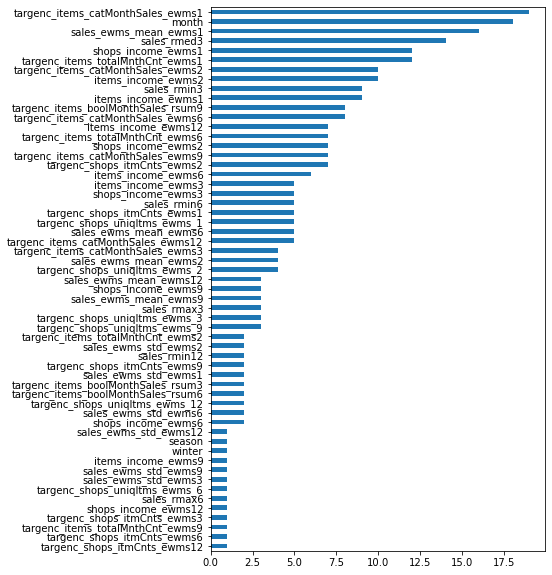

In [121]:
plot_feature_importances(res1.fitted_models['FINAL'])

In [122]:
mod = xgb_model(num_boost_round=50, max_depth=10, eta=0.3, gpu_id=0, tree_method='gpu_hist')
res2 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=12, fit_final=True)
res2.scores

Working on: 2015-02
fit time: 95.05977010726929
Working on: 2015-03
fit time: 90.96761965751648
Working on: 2015-04
fit time: 97.91706371307373
Working on: 2015-05
fit time: 98.27807927131653
Working on: 2015-06
fit time: 91.38852381706238
Working on: 2015-07
fit time: 87.09301424026489
Working on: 2015-08
fit time: 93.08003377914429
Working on: 2015-09
fit time: 93.1081154346466


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-02,1.268564,1.450595,2.603027,3.178538
2015-03,1.254114,1.445918,3.398318,4.303982
2015-04,1.455232,1.695348,2.286142,3.036509
2015-05,1.503091,1.774480,1.222410,1.639645
2015-06,1.499166,1.794777,0.832718,1.121660
2015-07,1.488133,1.807976,1.130991,1.436490
2015-08,1.479025,1.826270,4.488036,6.248048
2015-09,1.442252,1.802917,3.491969,4.343675
FINAL,NaN,1.323857,NaN,NaN


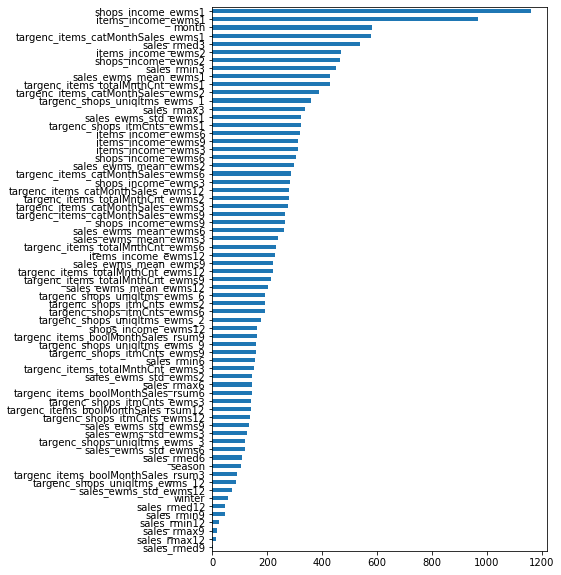

In [123]:
plot_feature_importances(res2.fitted_models['FINAL'])

In [124]:
mod = xgb_model(num_boost_round=100, max_depth=20, eta=0.3, gpu_id=0, tree_method='gpu_hist')
res3 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=12, fit_final=True)
res3.scores

Working on: 2015-02
fit time: 296.80003118515015
Working on: 2015-03
fit time: 306.5429608821869
Working on: 2015-04
fit time: 305.735232591629
Working on: 2015-05
fit time: 292.404780626297
Working on: 2015-06
fit time: 301.44265818595886
Working on: 2015-07
fit time: 287.65748167037964
Working on: 2015-08
fit time: 306.8202202320099
Working on: 2015-09
fit time: 317.7910716533661


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-02,1.103620,1.260560,2.756418,3.373394
2015-03,1.078652,1.242450,3.396154,4.283126
2015-04,1.338002,1.558100,2.281691,3.041809
2015-05,1.391212,1.641602,1.396756,1.856846
2015-06,1.390819,1.664235,0.896195,1.196928
2015-07,1.381999,1.677913,1.062465,1.336983
2015-08,1.376941,1.700054,4.519049,6.266175
2015-09,1.343191,1.678677,3.650917,4.644114
FINAL,NaN,1.218527,NaN,NaN


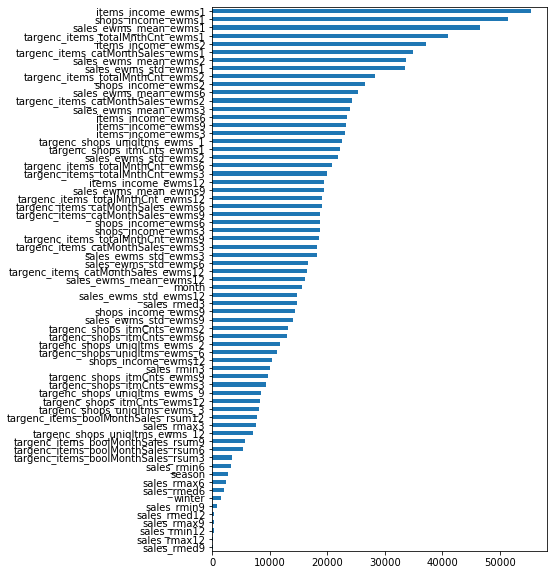

In [125]:
plot_feature_importances(res3.fitted_models['FINAL'])

In [126]:
mod = xgb_model(num_boost_round=200, max_depth=20, eta=0.3, gpu_id=0, tree_method='gpu_hist')
res4 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=12, fit_final=True)
res4.scores

Working on: 2015-02
fit time: 401.106990814209
Working on: 2015-03
fit time: 408.81337308883667
Working on: 2015-04
fit time: 394.7091064453125
Working on: 2015-05
fit time: 400.81578731536865
Working on: 2015-06
fit time: 386.3305196762085
Working on: 2015-07
fit time: 356.5093479156494
Working on: 2015-08
fit time: 369.0637471675873
Working on: 2015-09
fit time: 365.53315567970276


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-02,1.094359,1.250123,2.870594,3.511037
2015-03,1.070885,1.233333,3.386031,4.261713
2015-04,1.332641,1.551663,2.287803,2.999698
2015-05,1.385353,1.634417,1.369014,1.824822
2015-06,1.385920,1.658741,0.885143,1.179861
2015-07,1.376893,1.671764,0.970745,1.185029
2015-08,1.372644,1.694153,4.543091,6.308939
2015-09,1.339488,1.673759,3.719256,4.675862
FINAL,NaN,1.214074,NaN,NaN


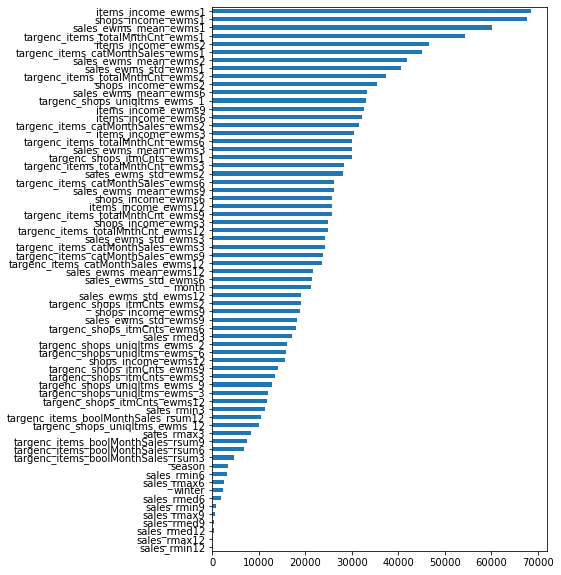

In [127]:
plot_feature_importances(res4.fitted_models['FINAL'])

### Random Forrest

In [ ]:
mod = RandomForestRegressor(n_estimators=100, max_depth=5, n_jobs=-1)
res5 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=12, fit_final=True)
res5.scores

Working on: 2015-02
fit time: 2781.675857067108
Working on: 2015-03
fit time: 2823.1747167110443
Working on: 2015-04


In [ ]:
plot_feature_importances(res5.fitted_models['FINAL'])

### Linear Model

In [212]:
mod = LinearRegression()
fitted_models, isscores, osscores, times = rolling_cross_validation(mod, months[13:], num_lagged_values=0,  post_process_preds=lambda x: np.clip(x, 0,20), num_stack_months=12, fit_final=True)

Working on: 2015-02
fit time: 80.58129835128784
Working on: 2015-03
fit time: 112.34453630447388
Working on: 2015-04
fit time: 82.53764319419861
Working on: 2015-05
fit time: 111.03276467323303
Working on: 2015-06
fit time: 86.29245615005493
Working on: 2015-07
fit time: 96.05022025108337
Working on: 2015-08
fit time: 81.99297642707825
Working on: 2015-09
fit time: 102.60614681243896


In [213]:
pd.concat([pd.Series(isscores, name='inSampleRMSE'), pd.Series(osscores, name='outSampleRMSE')], axis=1)

,inSampleRMSE,outSampleRMSE
2015-02,3.276859,1.582601
2015-03,3.207774,4.490107
2015-04,3.319270,3.665398
2015-05,3.415128,2.075592
2015-06,3.415414,1.887234
2015-07,3.430303,1.969687
2015-08,3.440963,6.695402
2015-09,3.731332,5.219247
FINAL,3.043591,NaN


In [219]:
fitted_models['FINAL'].coef_

array([ 3.12574273e+00, -1.75789875e+01,  3.13284334e+01, -4.30184668e+01,
        4.57600290e+01, -1.81711770e+01, -6.86776623e-01,  5.97470903e+00,
       -1.91067922e+01,  6.53419483e+01, -1.07164011e+02,  5.51536610e+01,
       -1.88443690e-05,  1.25016372e-04, -2.09950996e-04,  3.05900372e-04,
       -3.37809208e-04,  1.35138353e-04,  4.35773195e-07, -1.96074045e-06,
        2.25377399e-06, -5.30107211e-07, -3.08494377e-06,  2.87819596e-06,
       -3.77551385e-02, -3.77551230e-02, -3.77551372e-02, -3.77551324e-02,
       -2.69782901e-02, -2.69782920e-02, -2.69782805e-02, -2.69782847e-02,
       -1.62014577e-02, -1.62014613e-02, -1.62014612e-02, -1.62014613e-02,
       -1.19651198e-03,  9.95776028e-03, -2.17316180e-02,  5.32102154e-02,
       -7.67922067e-02,  3.66218938e-02,  3.42097840e-03, -3.15958923e-02,
        7.03021668e-02, -1.70186007e-01,  2.49755211e-01, -1.21724269e-01,
       -1.25173120e-04,  1.27107704e-03, -2.19753938e-03,  1.60137919e-03,
        1.85096965e-04, -

Parameter hypertuning:
- num_boost_rounds: 10 - 500
- max_depth: 5 - 30
- eta : 0.5 - 0.01

# Preparing Submission

In [ ]:
def merge_pred_with_test(prediction, fill_val=0, pred_col='item_cnt_month'):
    assert pred_col in prediction.columns, f'Couldnt find {pred_col}'
    data_fol = 'data'
    test = pd.read_csv(os.path.join(data_fol, 'test.csv'))
    merged =  pd.merge(test, prediction, on=['shop_id', 'item_id'], how='left').fillna(fill_val)
    if pred_col != 'item_cnt_month':
        merged = merged.rename(columns={pred_col:'item_cnt_month'})
    return merged.set_index('ID')['item_cnt_month']